<a href="https://colab.research.google.com/github/mafudsetiono/Portofolio-Forecast/blob/main/TimeSeries_Forecast_Porto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================
# Core Libraries
# =========================
import pandas as pd
import numpy as np

# =========================
# Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Time Series & Forecasting
# =========================
from prophet import Prophet

# =========================
# Model Evaluation
# =========================
from sklearn.metrics import mean_absolute_error, mean_squared_error

# =========================
# Utilities
# =========================
import warnings
warnings.filterwarnings("ignore")

# =========================
# Plot Settings
# =========================
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


#Load Data

In [ ]:
df = pd.read_csv("/content/sample_superstore.csv", encoding='latin1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [ ]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


Dataset Superstore bersih dari missing value, namun memerlukan konversi tipe data tanggal sebelum analisis time series dan forecasting.

#Data Clean

In [ ]:
# Copy dataframe agar aman
df_clean = df.copy()

# Convert Order Date & Ship Date ke datetime
df_clean["Order Date"] = pd.to_datetime(df_clean["Order Date"])
df_clean["Ship Date"] = pd.to_datetime(df_clean["Ship Date"])

# Sort berdasarkan waktu
df_clean = df_clean.sort_values("Order Date")

# Set Order Date sebagai index (sementara)
df_clean = df_clean.set_index("Order Date")

df_clean.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2014-01-03,7981,CA-2014-103800,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,Texas,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512
2014-01-04,740,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717
2014-01-04,741,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748
2014-01-04,742,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,Illinois,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870
2014-01-05,1760,CA-2014-141817,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,Pennsylvania,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840


In [ ]:
df_clean.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-04', '2014-01-04',
               '2014-01-05', '2014-01-06', '2014-01-06', '2014-01-06',
               '2014-01-06', '2014-01-06',
               ...
               '2017-12-29', '2017-12-29', '2017-12-29', '2017-12-30',
               '2017-12-30', '2017-12-30', '2017-12-30', '2017-12-30',
               '2017-12-30', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=9994, freq=None)

In [ ]:
df_clean.index.min(), df_clean.index.max()

(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [ ]:
# Agregasi sales per minggu
weekly_sales = (
    df_clean["Sales"]
    .resample("W")
    .sum()
    .reset_index()
)

weekly_sales.head()

,Order Date,Sales
0,2014-01-05,324.044
1,2014-01-12,4599.572
2,2014-01-19,4509.127
3,2014-01-26,3842.388
4,2014-02-02,1642.310


In [ ]:
# rename untuk Prophet
weekly_sales.columns = ["ds", "y"]

weekly_sales.head()

,ds,y
0,2014-01-05,324.044
1,2014-01-12,4599.572
2,2014-01-19,4509.127
3,2014-01-26,3842.388
4,2014-02-02,1642.310


In [ ]:
# Agregasi sales per bulan
monthly_sales = (
    df_clean["Sales"]
    .resample("M")
    .sum()
    .reset_index()
)

monthly_sales.head()

,Order Date,Sales
0,2014-01-31,14236.895
1,2014-02-28,4519.892
2,2014-03-31,55691.009
3,2014-04-30,28295.345
4,2014-05-31,23648.287


In [ ]:
monthly_sales.tail()

,Order Date,Sales
43,2017-08-31,63120.8880
44,2017-09-30,87866.6520
45,2017-10-31,77776.9232
46,2017-11-30,118447.8250
47,2017-12-31,83829.3188


In [ ]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Order Date  48 non-null     datetime64[ns]
 1   Sales       48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


Data transaksi harian diagregasi ke tingkat bulanan untuk mengurangi noise dan menangkap pola tren serta musiman penjualan.

#EDA - Time Series EDA

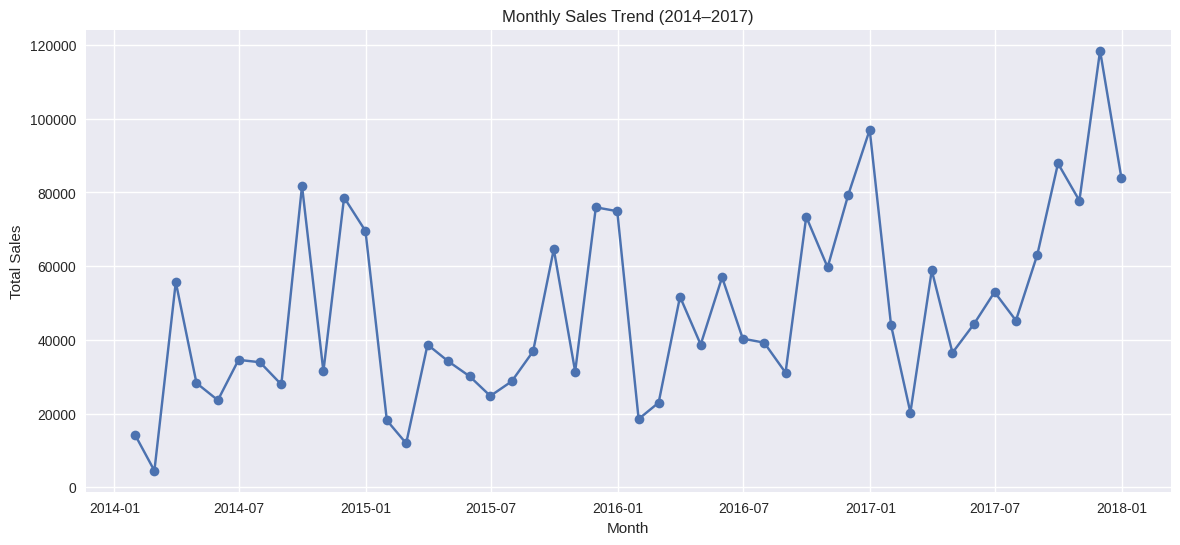

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(monthly_sales["Order Date"], monthly_sales["Sales"], marker="o")
plt.title("Monthly Sales Trend (2014–2017)")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

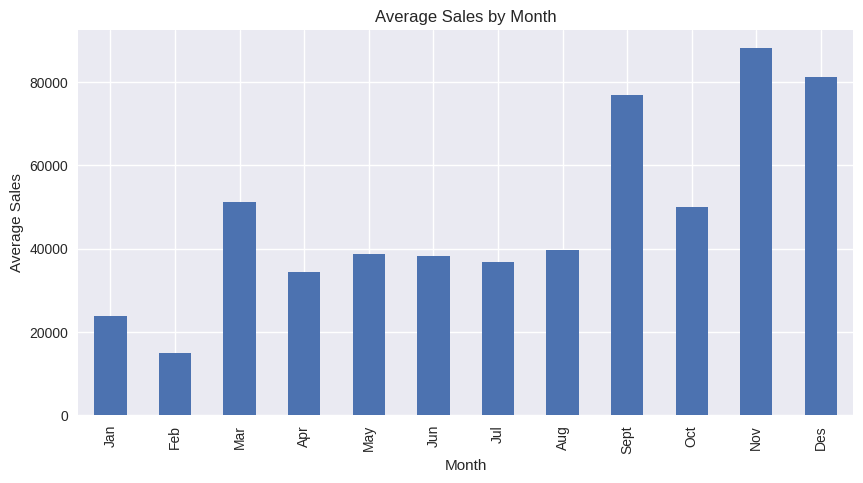

In [ ]:
monthly_sales["Month"] = monthly_sales["Order Date"].dt.month

avg_monthly = monthly_sales.groupby("Month")["Sales"].mean()

plt.figure(figsize=(10,5))
avg_monthly.plot(kind="bar")
plt.title("Average Sales by Month")
plt.xticks(ticks=np.arange(12), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Des"])
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

**Insight**

Analisis time series menunjukkan adanya tren peningkatan penjualan dari tahun ke tahun serta pola musiman yang konsisten, dengan puncak penjualan terjadi pada kuartal akhir (Q4) dan penurunan pada awal tahun.

#Train - Test Split

In [ ]:
# Copy data monthly
ts_data = weekly_sales.copy()

# Rename kolom sesuai format Prophet
ts_data = ts_data.rename(columns={
    "Order Date": "ds",
    "Sales": "y"
})

ts_data.head()

,ds,y
0,2014-01-05,324.044
1,2014-01-12,4599.572
2,2014-01-19,4509.127
3,2014-01-26,3842.388
4,2014-02-02,1642.310


In [ ]:
# Train data
train = ts_data[ts_data["ds"] <= "2017-06-30"]

# Test data
test = ts_data[ts_data["ds"] > "2017-06-30"]

train.shape, test.shape

((182, 2), (27, 2))

#Modeling

##Naive Forecast

In [ ]:
# Copy train & test agar aman
train_baseline = train.copy()
test_baseline = test.copy()

# Naive forecast: y(t) = y(t-1)
last_train_value = train_baseline["y"].iloc[-1]

test_baseline["naive_forecast"] = last_train_value

test_baseline[["ds", "y", "naive_forecast"]]

,ds,y,naive_forecast
42,2017-07-31,45264.4160,52981.7257
43,2017-08-31,63120.8880,52981.7257
44,2017-09-30,87866.6520,52981.7257
45,2017-10-31,77776.9232,52981.7257
46,2017-11-30,118447.8250,52981.7257
47,2017-12-31,83829.3188,52981.7257


#Moving Avarage Forecast

In [ ]:
# Hitung rolling mean di data train
rolling_3 = train_baseline["y"].rolling(window=3).mean()

# Ambil nilai rolling terakhir
ma_3_value = rolling_3.iloc[-1]

# Assign ke test
test_baseline["ma_3_forecast"] = ma_3_value

test_baseline[["ds", "y", "ma_3_forecast"]]

,ds,y,ma_3_forecast
42,2017-07-31,45264.4160,44588.124
43,2017-08-31,63120.8880,44588.124
44,2017-09-30,87866.6520,44588.124
45,2017-10-31,77776.9232,44588.124
46,2017-11-30,118447.8250,44588.124
47,2017-12-31,83829.3188,44588.124


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Naive
mae_naive = mean_absolute_error(
    test_baseline["y"],
    test_baseline["naive_forecast"]
)

rmse_naive = np.sqrt(mean_squared_error(
    test_baseline["y"],
    test_baseline["naive_forecast"]
))

# Moving Average
mae_ma3 = mean_absolute_error(
    test_baseline["y"],
    test_baseline["ma_3_forecast"]
)

rmse_ma3 = np.sqrt(mean_squared_error(
    test_baseline["y"],
    test_baseline["ma_3_forecast"]
))

print(f"MAE Naive :{mae_naive}")
print(f"RMSE Naive :{rmse_naive}")
print(f"MAE MA3 :{mae_ma3}")
print(f"RMSE MA3 :{rmse_ma3}")

MAE Naive :28975.048033333336
RMSE Naive :34716.71917293002
MAE MA3 :34796.213166666676
RMSE MA3 :41459.9704367048


Baseline forecasting menunjukkan tingkat error yang relatif tinggi, sehingga diperlukan model yang mampu menangkap tren dan pola musiman penjualan secara lebih baik.

Sebagai benchmark awal, digunakan pendekatan baseline forecasting berupa naive forecast dan moving average. Baseline ini berfungsi sebagai tolok ukur minimum performa sebelum menerapkan model forecasting yang lebih kompleks.

#Prophet Modeling

##Weekly

In [ ]:
from prophet import Prophet

weekly_model = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.2,
    interval_width=0.8  # 80% CI

)


weekly_model.fit(weekly_sales)

In [ ]:
future = weekly_model.make_future_dataframe(periods=12, freq="W")
forecast = weekly_model.predict(future)

forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
216,2018-02-25,7644.553742,487.026629,13832.453777
217,2018-03-04,10462.612328,4162.485308,17222.752966
218,2018-03-11,15099.480837,8474.914807,21502.242739
219,2018-03-18,18694.286482,11930.434777,25253.182077
220,2018-03-25,19288.492603,12492.126718,25669.959097


In [ ]:
# Ambil prediksi
# Filter the forecast to only include the dates present in the 'test' dataframe
forecast_for_test = forecast[forecast['ds'].isin(test['ds'])]

# Ensure the order of predictions matches the order of 'test' dataframe
# This is crucial for correct error calculation
y_pred_prophet = forecast_for_test.set_index('ds').reindex(test['ds'])['yhat']

# Hitung error
mae_prophet = mean_absolute_error(
    test["y"],
    y_pred_prophet
)
rmse_prophet = np.sqrt(mean_squared_error(
    test["y"],
    y_pred_prophet
))

mae_prophet, rmse_prophet

(5420.286818390935, np.float64(6702.0073607803315))

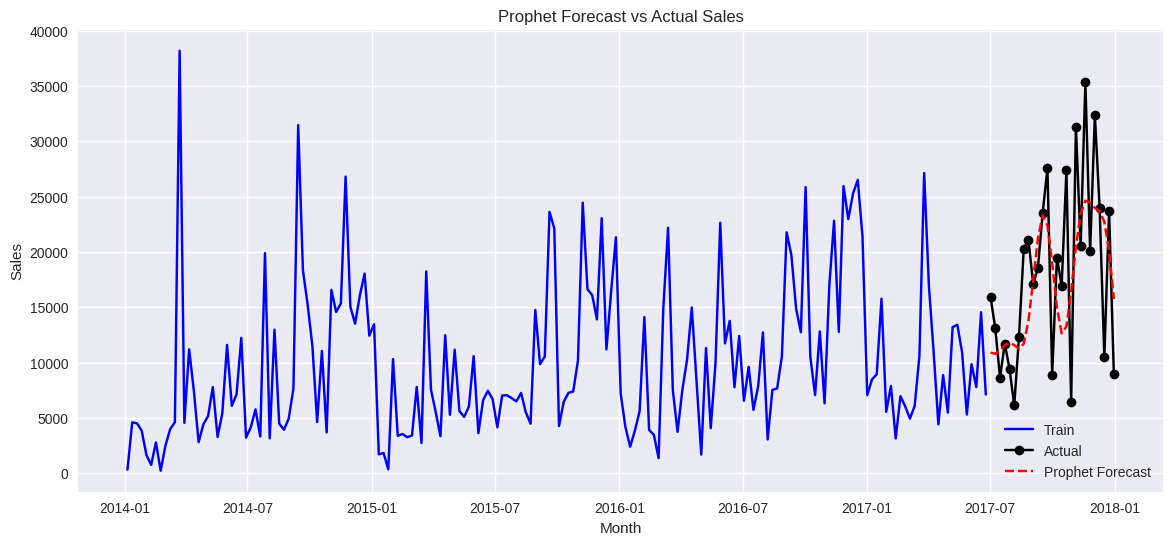

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train["ds"], train["y"], label="Train", color="blue")
plt.plot(test["ds"], test["y"], label="Actual", marker="o", color="black")
plt.plot(test["ds"], y_pred_prophet, label="Prophet Forecast", linestyle="--", color="red")
plt.title("Prophet Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()

##Monthly

In [ ]:
# Inisialisasi model Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

# Fit model
prophet_model.fit(train)

In [ ]:
# Buat dataframe future (sebatas test period)
future_test = test[["ds"]]

# Prediksi
forecast_test = prophet_model.predict(future_test)

forecast_test[["ds", "yhat", "yhat_lower", "yhat_upper"]]

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-31,45436.907155,37181.843377,52598.064816
1,2017-08-31,40128.751935,32790.447181,47467.032219
2,2017-09-30,83477.799321,76325.501118,90226.077874
3,2017-10-31,55960.844227,48402.417284,63037.361668
4,2017-11-30,86620.032898,79212.138334,93759.854145
5,2017-12-31,93619.069037,86044.389093,101000.666306


In [ ]:
# Ambil prediksi
y_pred_prophet = forecast_test["yhat"]

# Hitung error
mae_prophet = mean_absolute_error(test["y"], y_pred_prophet)
rmse_prophet = np.sqrt(mean_squared_error(test["y"], y_pred_prophet))

mae_prophet, rmse_prophet

(15164.51686871462, np.float64(18853.46547934117))

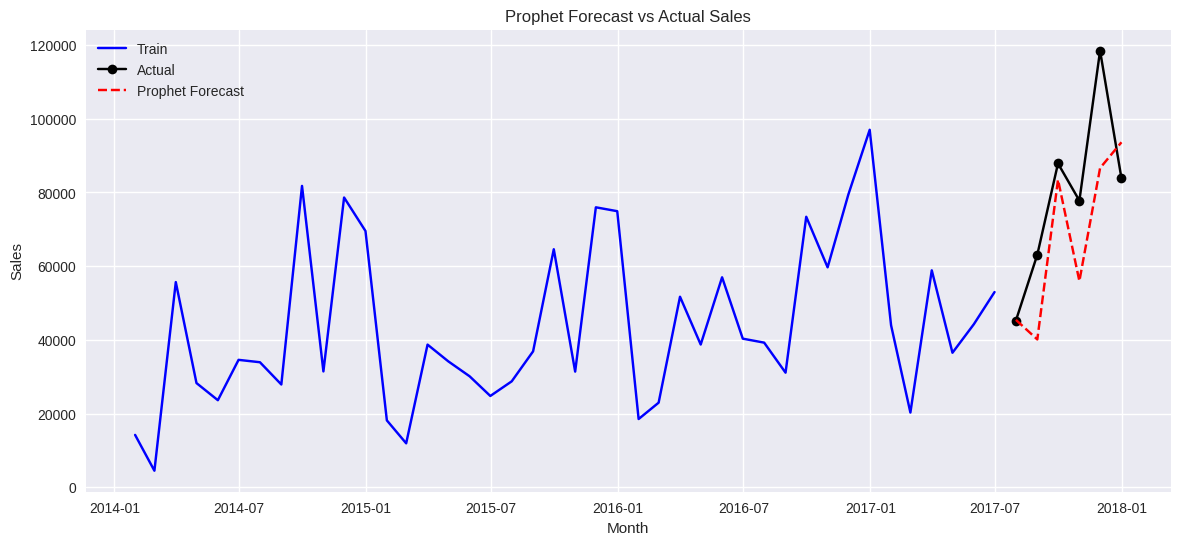

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(train["ds"], train["y"], label="Train", color="blue")
plt.plot(test["ds"], test["y"], label="Actual", marker="o", color="black")
plt.plot(test["ds"], y_pred_prophet, label="Prophet Forecast", linestyle="--", color="red")
plt.title("Prophet Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.show()

##Insight
Model Prophet berhasil menurunkan error forecasting secara signifikan dibandingkan baseline, menunjukkan kemampuannya dalam menangkap tren dan pola musiman penjualan.

In [ ]:
prophet_tuned = Prophet(
    yearly_seasonality=True,
    seasonality_mode="multiplicative",
    changepoint_prior_scale=0.1
)

prophet_tuned.fit(train)

forecast_tuned = prophet_tuned.predict(test[["ds"]])

mae_tuned = mean_absolute_error(test["y"], forecast_tuned["yhat"])
rmse_tuned = np.sqrt(mean_squared_error(test["y"], forecast_tuned["yhat"]))

mae_tuned, rmse_tuned

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(15310.80659354435, np.float64(17563.416373997283))

Meskipun dilakukan tuning parameter Prophet, model default tetap dipilih sebagai model final karena memberikan performa yang lebih stabil dengan rata-rata error yang lebih rendah.

#Random Forest

In [ ]:
# Copy data
rf_data = ts_data.copy()

# Lag features
rf_data["lag_1"] = rf_data["y"].shift(1)
rf_data["lag_2"] = rf_data["y"].shift(2)
rf_data["lag_3"] = rf_data["y"].shift(3)

# Rolling mean
rf_data["rolling_3"] = rf_data["y"].rolling(window=3).mean()

rf_data.head()

,ds,y,Month,lag_1,lag_2,lag_3,rolling_3
0,2014-01-31,14236.895,1,NaN,NaN,NaN,NaN
1,2014-02-28,4519.892,2,14236.895,NaN,NaN,NaN
2,2014-03-31,55691.009,3,4519.892,14236.895,NaN,24815.932000
3,2014-04-30,28295.345,4,55691.009,4519.892,14236.895,29502.082000
4,2014-05-31,23648.287,5,28295.345,55691.009,4519.892,35878.213667


In [ ]:
# Drop baris awal yang NA
rf_data = rf_data.dropna()

# Train–test split berdasarkan waktu
rf_train = rf_data[rf_data["ds"] <= "2017-06-30"]
rf_test = rf_data[rf_data["ds"] > "2017-06-30"]

X_train = rf_train[["lag_1", "lag_2", "lag_3", "rolling_3"]]
y_train = rf_train["y"]

X_test = rf_test[["lag_1", "lag_2", "lag_3", "rolling_3"]]
y_test = rf_test["y"]

X_train.shape, X_test.shape

((39, 4), (6, 4))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [ ]:
# Predict
y_pred_rf = rf_model.predict(X_test)

# Error
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

mae_rf, rmse_rf

(17214.27216775, np.float64(22879.609818475077))

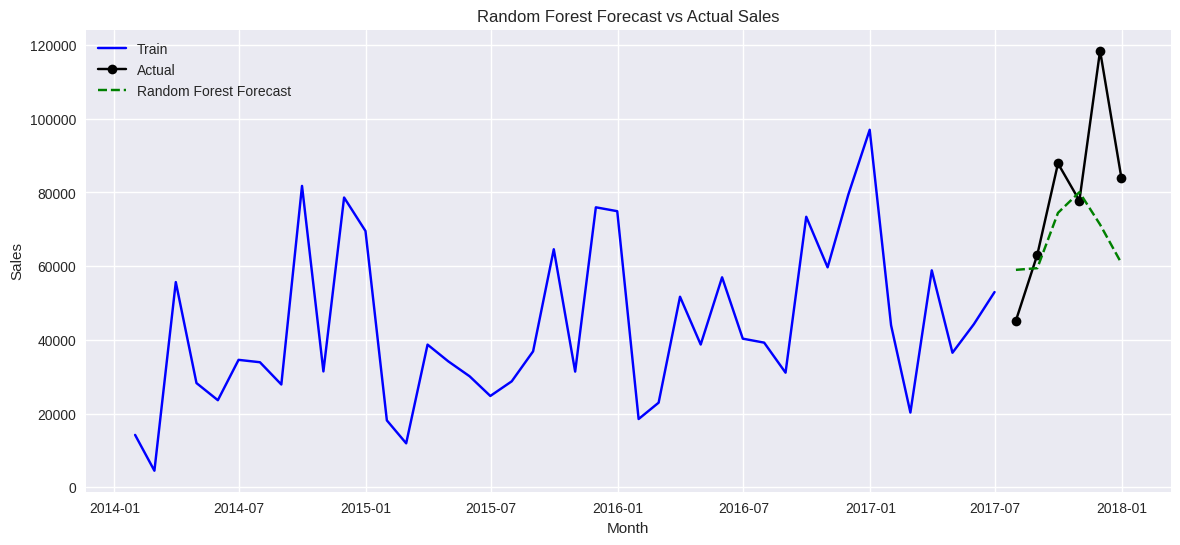

In [ ]:
plt.figure(figsize=(14,6))

plt.plot(
    train["ds"], train["y"],
    label="Train", color="blue"
)

plt.plot(
    test["ds"], test["y"],
    label="Actual", marker="o", color="black"
)

plt.plot(
    rf_test["ds"], y_pred_rf,
    label="Random Forest Forecast", linestyle="--", color="green"
)

plt.title("Random Forest Forecast vs Actual Sales")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
comparison = pd.DataFrame({
    "Model": [
        "Naive Forecast",
        "Moving Average (3)",
        "Prophet (Default)",
        "Prophet (Tuned)",
        "Random Forest"
    ],
    "MAE": [
        mae_naive,
        mae_ma3,
        mae_prophet,
        mae_tuned,
        mae_rf
    ],
    "RMSE": [
        rmse_naive,
        rmse_ma3,
        rmse_prophet,
        rmse_tuned,
        rmse_rf
    ]
})

comparison

,Model,MAE,RMSE
0,Naive Forecast,28975.048033,34716.719173
1,Moving Average (3),34796.213167,41459.970437
2,Prophet (Default),15164.516869,18853.465479
3,Prophet (Tuned),15310.806594,17563.416374
4,Random Forest,17214.272168,22879.609818


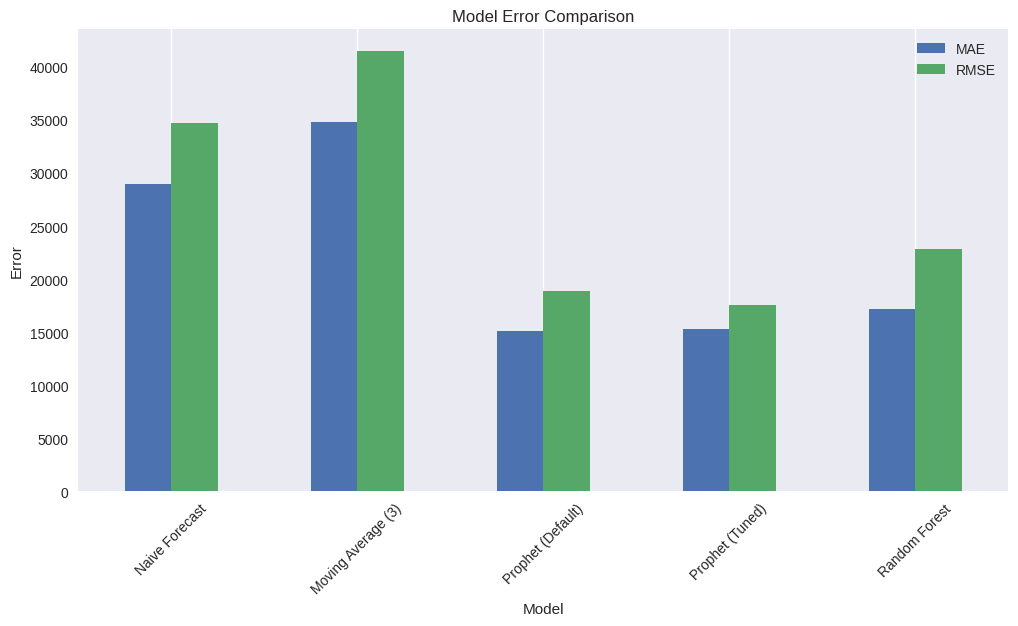

In [ ]:
comparison.set_index("Model")[["MAE", "RMSE"]].plot(
    kind="bar",
    figsize=(12,6)
)
plt.title("Model Error Comparison")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

## Insight

Meskipun pendekatan machine learning berbasis Random Forest digunakan sebagai pembanding, model Prophet memberikan performa terbaik dalam memprediksi penjualan bulanan karena kemampuannya menangkap tren dan pola musiman secara eksplisit.


#Eksecutive Sumary

Berdasarkan analisis penjualan historis periode 2014–2017, ditemukan adanya tren peningkatan penjualan dengan pola musiman yang konsisten. Model Prophet memberikan performa terbaik dalam memprediksi penjualan bulanan dibandingkan baseline sederhana dan pendekatan machine learning Random Forest.

- Insight 1 — Tren Jangka Panjang Positif

  - Penjualan menunjukkan tren meningkat dari tahun ke tahun

  - Artinya bisnis berada dalam fase growth

  - Implikasi bisnis:

  - Perencanaan stok & kapasitas bisa ditingkatkan bertahap

  - Fokus pada ekspansi, bukan sekadar efisiensi

- Insight 2 — Seasonality Kuat di Akhir Tahun

  - Puncak penjualan terjadi di:

    - September

    - November

    - Desember

  - Awal tahun (Jan–Feb) cenderung lebih rendah

  - Implikasi bisnis:

    - Tingkatkan stok & logistik menjelang Q4

    - Jadwalkan promo besar di bulan performa tinggi

    - Lakukan clearance / promo agresif di awal tahun

In [ ]:
import pickle

# Simpan model prophet
with open("prophet_sales_model.pkl", "wb") as f:
    pickle.dump(prophet_model, f)

In [ ]:
import pickle

# Simpan model weekly prophet
with open("prophet_sales_weekly.pkl", "wb") as f:
    pickle.dump(weekly_model, f)